프로젝트: 고양이 수염 스티커 만들기
=====

Step 1. 스티커 구하기 or 만들기
---------
<br/>
- 스티커는 노드에 있는 flaticon 이미지를 사용하였습니다.

Step 2. 얼굴 검출 & 랜드마크 검출 하기
--------

- opencv,matplotlib & image resize

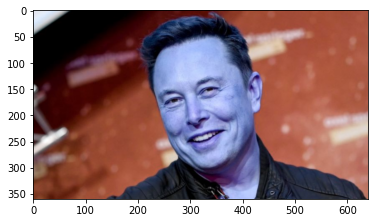

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/musk.jpeg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()
img_show2 = img_bgr.copy()
img_show3 = img_bgr.copy()
img_show4 = img_bgr.copy()   #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

- dilb을 활용하여 hog detector 선언 및 bounding box 추출

In [2]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) #rgb 변환
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

rectangles[[(221, 98) (407, 284)]]


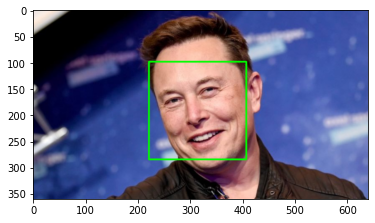

In [3]:
print(dlib_rects)   # 찾은 얼굴 영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

- landmark 출력

68


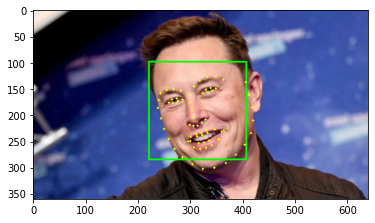

In [4]:
# landmark load
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)


list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts())) #직관적인 x,y 형태로 변환
    list_landmarks.append(list_points)

print(len(list_landmarks[0])) 


for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

Step 3. 스티커 적용 위치 확인하기
------

- 볼의 위치를 알기위해 landmark 순서 그림을 load

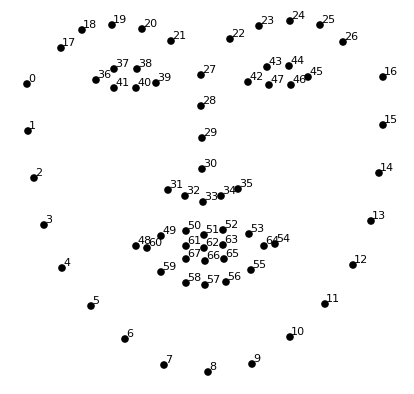

In [5]:
from PIL import Image
import os

landmark_guide = os.getenv('HOME')+'/aiffel/camera_sticker/images/landmark.png'
landmark = Image.open(landmark_guide)
landmark


- 이미지는 볼을 기준으로 잡아야하므로 2 48 30 40 번 인덱스를 이용한다.

In [6]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print ('left :',landmark[2],'top :',landmark[36],'right :',landmark[30],'bottom :',landmark[48]) 
    left_x = landmark[2][0] # left index : 2
    left_y = landmark[2][1] 
    top_x = landmark[36][0] # top index : 36
    top_y = landmark[36][1]
    right_x = landmark[30][0] # right index : 30
    right_y = landmark[30][1]
    bottom_x = landmark[48][0] # bottom index : 48
    bottom_y = landmark[48][1]
    x = ((left_x + right_x) //2) 
    y = ((top_y + bottom_y) // 2) 
    w = dlib_rect.width()
    h = dlib_rect.height()
    
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

left : (250, 226) top : (259, 176) right : (305, 205) bottom : (296, 250)
(x,y) : (277,213)
(w,h) : (187,187)


- 위에서 계산한 w,h 값으로 resize

(187, 187, 3)


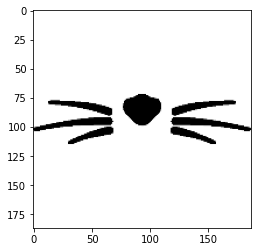

In [7]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
img_sticker_rgb = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)
plt.imshow(img_sticker_rgb)
plt.show
print (img_sticker.shape)


- 이미지의 시작점은 top-left 이므로 x,y 좌표를 조정

In [8]:
refined_x = x -w//2 # left
refined_y = y -h//2 # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (184,120)


Step 4. 스티커 적용하기
------

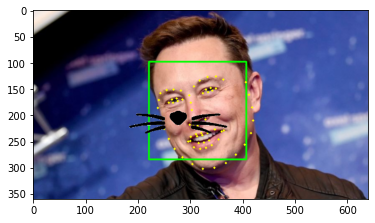

In [9]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

- 노드를 참고하여 볼 위치에 맞추려고 노력하였는데 보기가 싫다<br/> 이 상태에서 코에 한번 맞춰보자

In [10]:
refined_x = x -w//2 + (landmark[30][0] - x)  # left
refined_y = y -h//2 # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (212,120)


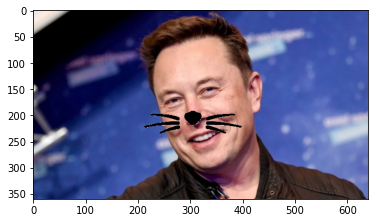

In [11]:
sticker_area = img_show4[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show4[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show4, cv2.COLOR_BGR2RGB))
plt.show()

- 이번엔 코끝인 30에 맞춰보았다.

In [12]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30])
    new_x = landmark[30][0]
    new_y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.height()
    
    print ('(new_x,new_y) : (%d,%d)'%(new_x,new_y))
    print ('(w,h) : (%d,%d)'%(w,h))

(305, 205)
(new_x,new_y) : (305,205)
(w,h) : (187,187)


In [13]:
new_refined_x = new_x -w//2  # left
new_refined_y = new_y -h//2 # top
print ('(x,y) : (%d,%d)'%(new_refined_x, new_refined_y))

(x,y) : (212,112)


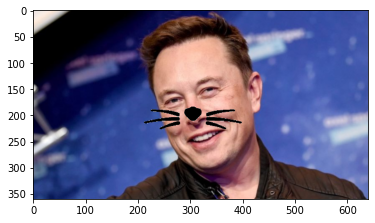

In [14]:
sticker_area = img_show2[new_refined_y:new_refined_y+img_sticker.shape[0], new_refined_x:new_refined_x+img_sticker.shape[1]]
img_show2[new_refined_y:new_refined_y+img_sticker.shape[0], new_refined_x:new_refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show2, cv2.COLOR_BGR2RGB))
plt.show()

- 이제 cv2.addWeighted를 활용하여 opacity를 조절해보자.

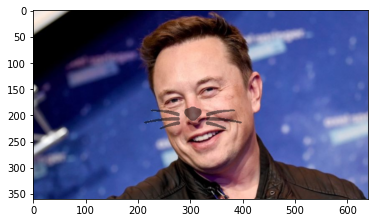

In [15]:
sticker_area = img_show3[new_refined_y:new_refined_y+img_sticker.shape[0], new_refined_x:new_refined_x+img_sticker.shape[1]]
img_show3[new_refined_y:new_refined_y+img_sticker.shape[0], new_refined_x:new_refined_x+img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8), 0.5, 0)

plt.imshow(cv2.cvtColor(img_show3, cv2.COLOR_BGR2RGB))
plt.show()

Step 5. 문제점 찾아보기
------


- 자 이제 각도,밝기,촬영거리 다른 사진으로 실험해보자.

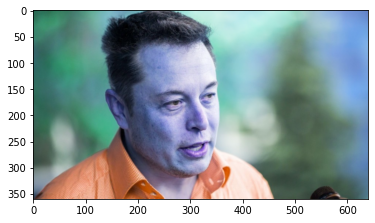

In [16]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/musk2.jpeg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy() #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

In [17]:
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) #rgb 변환
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

rectangles[[(191, 93) (414, 316)]]


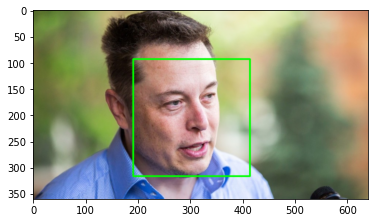

In [18]:
print(dlib_rects)   # 찾은 얼굴 영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

68


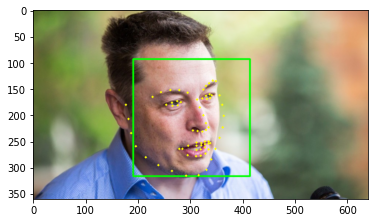

In [19]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)


list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts())) #직관적인 x,y 형태로 변환
    list_landmarks.append(list_points)

print(len(list_landmarks[0])) 


for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [20]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30])
    new_x = landmark[30][0]
    new_y = landmark[30][1]  
    w = dlib_rect.width() 
    h = dlib_rect.height()
    
    print ('(new_x,new_y) : (%d,%d)'%(new_x,new_y))
    print ('(w,h) : (%d,%d)'%(w,h))

(330, 215)
(new_x,new_y) : (330,215)
(w,h) : (224,224)


(224, 224, 3)


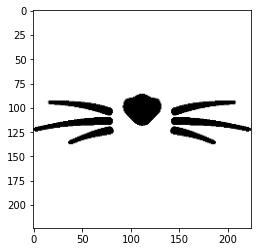

In [21]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
img_sticker_rgb = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)
plt.imshow(img_sticker_rgb)
plt.show
print (img_sticker.shape)


In [22]:
new_refined_x = new_x -w//2  # left
new_refined_y = new_y -h//2 # top
print ('(x,y) : (%d,%d)'%(new_refined_x, new_refined_y))

(x,y) : (218,103)


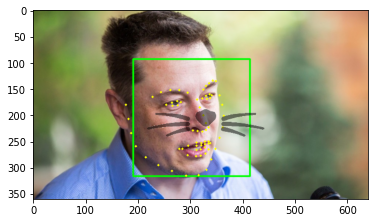

In [23]:
sticker_area = img_show[new_refined_y:new_refined_y+img_sticker.shape[0], new_refined_x:new_refined_x+img_sticker.shape[1]]
img_show[new_refined_y:new_refined_y+img_sticker.shape[0], new_refined_x:new_refined_x+img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8), 0.5, 0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

- 각도가 달라지니 오른쪽 수염부분이 얼굴을 벗어난 것을 볼 수 있다. <br/> 또 다른 사진으로 확인해보자

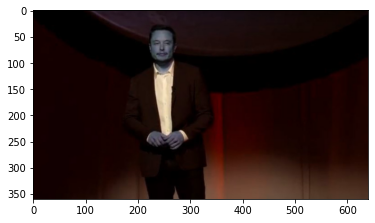

In [24]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/musk3.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy() #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

In [25]:
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) #rgb 변환
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

rectangles[[(223, 50) (266, 94)]]


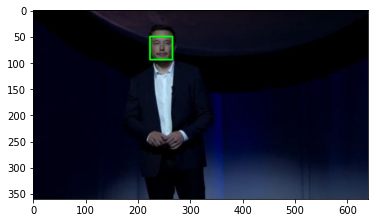

In [26]:
print(dlib_rects)   # 찾은 얼굴 영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

68


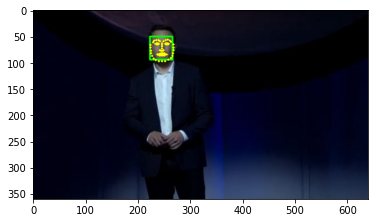

In [27]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)


list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts())) #직관적인 x,y 형태로 변환
    list_landmarks.append(list_points)

print(len(list_landmarks[0])) 


for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [28]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30])
    new_x = landmark[30][0]
    new_y = landmark[30][1]  
    w = dlib_rect.width() 
    h = dlib_rect.height()
    
    print ('(new_x,new_y) : (%d,%d)'%(new_x,new_y))
    print ('(w,h) : (%d,%d)'%(w,h))

(246, 73)
(new_x,new_y) : (246,73)
(w,h) : (44,45)


(45, 44, 3)


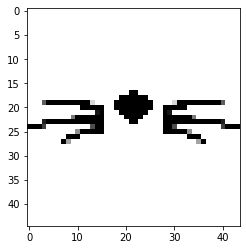

In [29]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
img_sticker_rgb = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)
plt.imshow(img_sticker_rgb)
plt.show
print (img_sticker.shape)


In [30]:
new_refined_x = new_x -w//2  # left
new_refined_y = new_y -h//2 # top
print ('(x,y) : (%d,%d)'%(new_refined_x, new_refined_y))

(x,y) : (224,51)


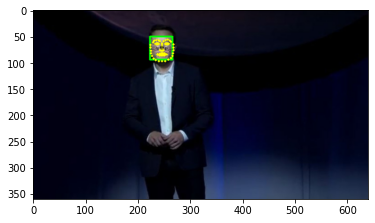

In [31]:
sticker_area = img_show[new_refined_y:new_refined_y+img_sticker.shape[0], new_refined_x:new_refined_x+img_sticker.shape[1]]
img_show[new_refined_y:new_refined_y+img_sticker.shape[0], new_refined_x:new_refined_x+img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8), 1, 0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

- 적용은 잘 되었으나 얼굴이 너무 작아 잘 안보인다.

회고
------

- np.where에서 예제에 나와있는대로 img_sticker==0일때를 설정했더니 흰 바탕에 수염부분이 뚫린채로 출력됐다.<br/> alpha 값 때문이라 생각이들어 255로 설정하여 잘 작동하는것을 확인하였다. 

- detector 선언 부분에서 rgb로 변환하지 않고 dlib_rect 할 경우 사각형은 물론 landmark 좌표 값 까지 다르게 잡히는 것을 볼 수 있었다.<br/> 아마도 dlib은 rgb이미지로 입력을 받기때문에 bgr의 이미지를 넣을경우 문제가 생기는 게 아닐까 싶다.

- 진행하면서 발견한 문제점들은<br/>
1. 얼굴 각도가 pan 축이 돌아가 있을때 스티커의 길이가 조절되지 않아 유독 한쪽 방향으로 튀어나오는 것을 볼 수 있다. <br/>이 경우 코끝(30)과 턱끝(2,14)의 길이를 측정하여 변화에 따라 중심을 기준으로 스티커의 좌우를 조절하는 방법이 있을 것 같다.<br/> 이때 사진을 distort 시켜야하는데 어떻게 할 수 있는지 더 공부해봐야겠다.    
2. 얼굴 각도가 roll 축으로 돌아가 있을때도 수염의 각도가 조절되면 좋을 것 같아 찾아보았다. <br/>수염 사진의 각도를 landmark에 연동하여 조절하는 것은 알게되었으나 같이 출력되게 하는건 너무 어려웠다.      
3. 사진에서 촬영거리가 너무 멀 경우 수염이 제대로 보이지 않았다. 잘 보이게 하려면 일정수준 이상 크기의 얼굴이 찍힌 원본이 중요하다.
4. 영상의 경우 실시간으로 얼굴 각도가 변하기 때문에 실행속도가 중요하다는 점을 파악할 수 있었다.<br/> 움직임보다 현저히 느릴경우 따라가느라 애쓰는 스티커를 볼 수 있을듯하다.      
5. 스티커앱을 만들 때 정확도가 나오지 않는다면 프레임 단위로 분석하기 때문에 스티커가 코에 정지되어 있는것이 아닌<br/> 눈으로 갔다 코로 갔다 귀로 갔다 배경으로 갔다 사방팔방 돌아다닐 것이다.    